# Jacobienne et Hessienne

La méthode `jax.grad` s'applique exclusivement aux fonctions à valeurs scalaires.

Ce qui correspond bien à l'usage courant en deep learning. On dérive la loss par rapport aux paramètres $\theta$. Le résultat $d\theta$ a la même shape que $\theta$:


Par exemple supposons que $\theta$ soit un vecteur:
$$
d\theta= (d\theta_i) \ \text{ avec pour chaque $i$: } d\theta_i= \frac{∂f}{∂\theta_i} (\theta)
$$

Et si maintenant $\theta$ soit est une matrice:
$$
d\theta= (d\theta_{ij}) \ \text{ avec pour chaque $ij$: } d\theta_i= \frac{∂f}{∂\theta_{ij}} (\theta)
$$

### Jacobienne

Si on veut dériver des fonctions à valeurs vectorielle, il faut utiliser la jacobienne: Supposons par exemple que $\theta$ est un vecteur et que $f(\theta)$ est aussi un vecteur. Alors

$$
J =(J_{ij})  \ \text{ avec pour chaque $i,j$: } J_{ij}= \frac{∂f_i}{∂\theta_j} (\theta)
$$
Attention à l'ordre des indices. Le premier est celui qui correspond à la dimension de l'espace d'arriver.

In [1]:
%reset -f

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np  # Pour le plot final (conversion jnp -> np)

Exemple avec une fonction de $\mathbb R^5$ dans $\mathbb R^{10}$:

In [3]:
def f(𝜃):
    return jnp.concat([𝜃,𝜃**2])

𝜃=jnp.ones([5])

f(𝜃).shape

In [4]:
J=jax.jacfwd(f)(𝜃)
J.shape

Exemple avec une fonction de $\mathbb R^{5\times 2}$ dans $\mathbb R^{10}$:

In [5]:
def f(𝜃):
    return jnp.concat([𝜃[:,0],𝜃[:,1]**2])

𝜃=jnp.ones([5,2])

f(𝜃).shape

In [6]:
J=jax.jacfwd(f)(𝜃)
J.shape

***A vous:*** De manière générale: Si $f$ prend en entrée un argument de shape `s1` et qu'il ressort un argument de shape `s2`. Quelle est la shape de la Jacobienne ?

## Dérivation forward.

* `jacfwd` signifie jacobienne-forward.
* `jacrev` signifie jacobienne-reverse.

La seconde correspond au mode de calcul des gradients: on effectue une backpropagation sur chaque sortie de la fonction.

La première correspond à une dérivation forward.

## Forward

 $y = h(g(f(x)))$. Nous voulons $\frac{dy}{dx}$

On veut propager le calcul de la source vers la cible. On utilise les nombres duaux.

### Introduction aux Nombres Duaux

Un nombre dual $a + b\epsilon$ est une extension des nombres réels où $\epsilon$ est un nombre infinitésimal non nul tel que $\epsilon^2 = 0$. Les règles d'arithmétique avec les nombres duaux sont les suivantes :

* $(a + b\epsilon) + (c + d\epsilon) = (a + c) + (b + d)\epsilon$
* $(a + b\epsilon)(c + d\epsilon) = ac + ad\epsilon + bc\epsilon + bd\epsilon^2 = ac + (ad + bc)\epsilon$ (puisque $\epsilon^2 = 0$)

La propriété clé
$$
f(x + c\epsilon) = f(x) + f'(x)c\epsilon
$$



### Application à la Fonction Composée $y = h(g(f(x)))$


1.  **Évaluation de $f(x)$ avec un nombre dual :**
    Entrons $x_0 + 1\epsilon$ dans la fonction $f$:
    $$
    f(x_0 + 1\epsilon) = f(x_0) + f'(x_0)\epsilon
    $$
    Notons
    * $u_0 = f(x_0)$ et $u_1 = f'(x_0)$.
    
    Le résultat est donc $u_0 + u_1\epsilon$.


2.  **Évaluation de $g(u)$:**
    Maintenant, entrons $u_0 + u_1\epsilon$ dans la fonction $g$:
    $$
    g(u_0 + u_1\epsilon) = g(u_0) + g'(u_0)(u_1\epsilon) = g(u_0) + g'(f(x_0))f'(x_0)\epsilon
    $$
    Notons
    * $v_0 = g(u_0) = g(f(x_0))$
    * $v_1 = g'(u_0)u_1 = g'(f(x_0))f'(x_0)$.

    Le résultat est donc $v_0 + v_1\epsilon$.

3.  **Évaluation de $h(v)$:**
    Enfin, entrons $v_0 + v_1\epsilon$ dans la fonction $h$:
    $$
    h(v_0 + v_1\epsilon) = h(v_0) + h'(v_0)(v_1\epsilon) = h(g(f(x_0))) + h'(g(f(x_0)))g'(f(x_0))f'(x_0)\epsilon
    $$
    Notons
    * $y_0 = h(v_0) = h(g(f(x_0)))$
    * $y_1 = h'(v_0)v_1 = h'(g(f(x_0)))g'(f(x_0))f'(x_0)$.
    

Par identification, le coefficient de $\epsilon$ dans le résultat final est la dérivée recherchée.





### En résumé

* Nous propageons une perturbation initiale (représentée par le coefficient de $\epsilon$) à travers chaque étape de la composition de la fonction.
* À chaque étape, la perturbation est transformée par la dérivée de la fonction interne.
* Le coefficient de $\epsilon$ dans le résultat final donne directement la dérivée de la fonction composée au point d'évaluation.

Pour une fonction avec une seule entrée, la dérivation forward avec les nombres duaux permet de calculer la valeur de la fonction et sa dérivée en une seule passe. C'est une méthode efficace pour la dérivation automatique dans ce cas.

### Plusieurs variables indépendances.


Pour calculer les dérivées partielles de $f(x,y)$ en $x_0$ et $y_0$ on fait 2 passages:  
* on fixe $y_0$ et on calcule $f(x_0,y_0+ 1 \epsilon )$
* on fixe $x_0$ et on calcule $f(x_01 \epsilon,y_0 )$

### Diagramme en diamant

Considérons une fonction de la forme $g(f_1(x), f_2(x))$


1.  **Propager la perturbation à travers les fonctions internes ($f_1$ et $f_2$) :**
    *  $f_1(x_0 + 1\epsilon)= f_1(x_0) + f_1'(x_0)\epsilon$.
    *  $f_2(x_0 + 1\epsilon)=f_2(x_0) + f_2'(x_0)\epsilon$.

2.  **Évaluer la fonction externe $g$ avec les résultats duaux :**
    
    $$g(f_1(x_0 + 1\epsilon), f_2(x_0 + 1\epsilon)) = g(f_1(x_0) + f_1'(x_0)\epsilon, f_2(x_0) + f_2'(x_0)\epsilon)$$

3.  **Utiliser les règles d'arithmétique des nombres duaux pour développer l'expression :**
    (similaire à un développement de Taylor)
    $$g(u_0 + u_1\epsilon, v_0 + v_1\epsilon) \approx g(u_0, v_0) + \frac{\partial g}{\partial u}(u_0, v_0) u_1\epsilon + \frac{\partial g}{\partial v}(u_0, v_0) v_1\epsilon$$
    On a déjà calculer toutes les valeurs:
    * $u_0 = f_1(x_0)$
    * $u_1 = f_1'(x_0)$
    * $v_0 = f_2(x_0)$
    * $v_1 = f_2'(x_0)$.

4.  **Identifitication finale:**
    $$
    g(f_1(x_0 + 1\epsilon), f_2(x_0 + 1\epsilon)) = y_0 + y_1\epsilon
    $$
    Le terme $y_1$ c'est la dérivée qu'on cherche. D'après l'étape précédente, on a :
    $$y_1 = \frac{\partial g}{\partial u}(f_1(x_0), f_2(x_0)) f_1'(x_0) + \frac{\partial g}{\partial v}(f_1(x_0), f_2(x_0)) f_2'(x_0)$$


On comprend ainsi qu'il faut utiliser:
* La dérivation forward quand la dimension d'entrée est plus petite que la dimension de sortie
* La dérivation reverse quand la dimension d'entrée est plus grande que la dimension de sortie (en particulier quand on dispose d'une fonction à valeur scalaire, telle une loss).

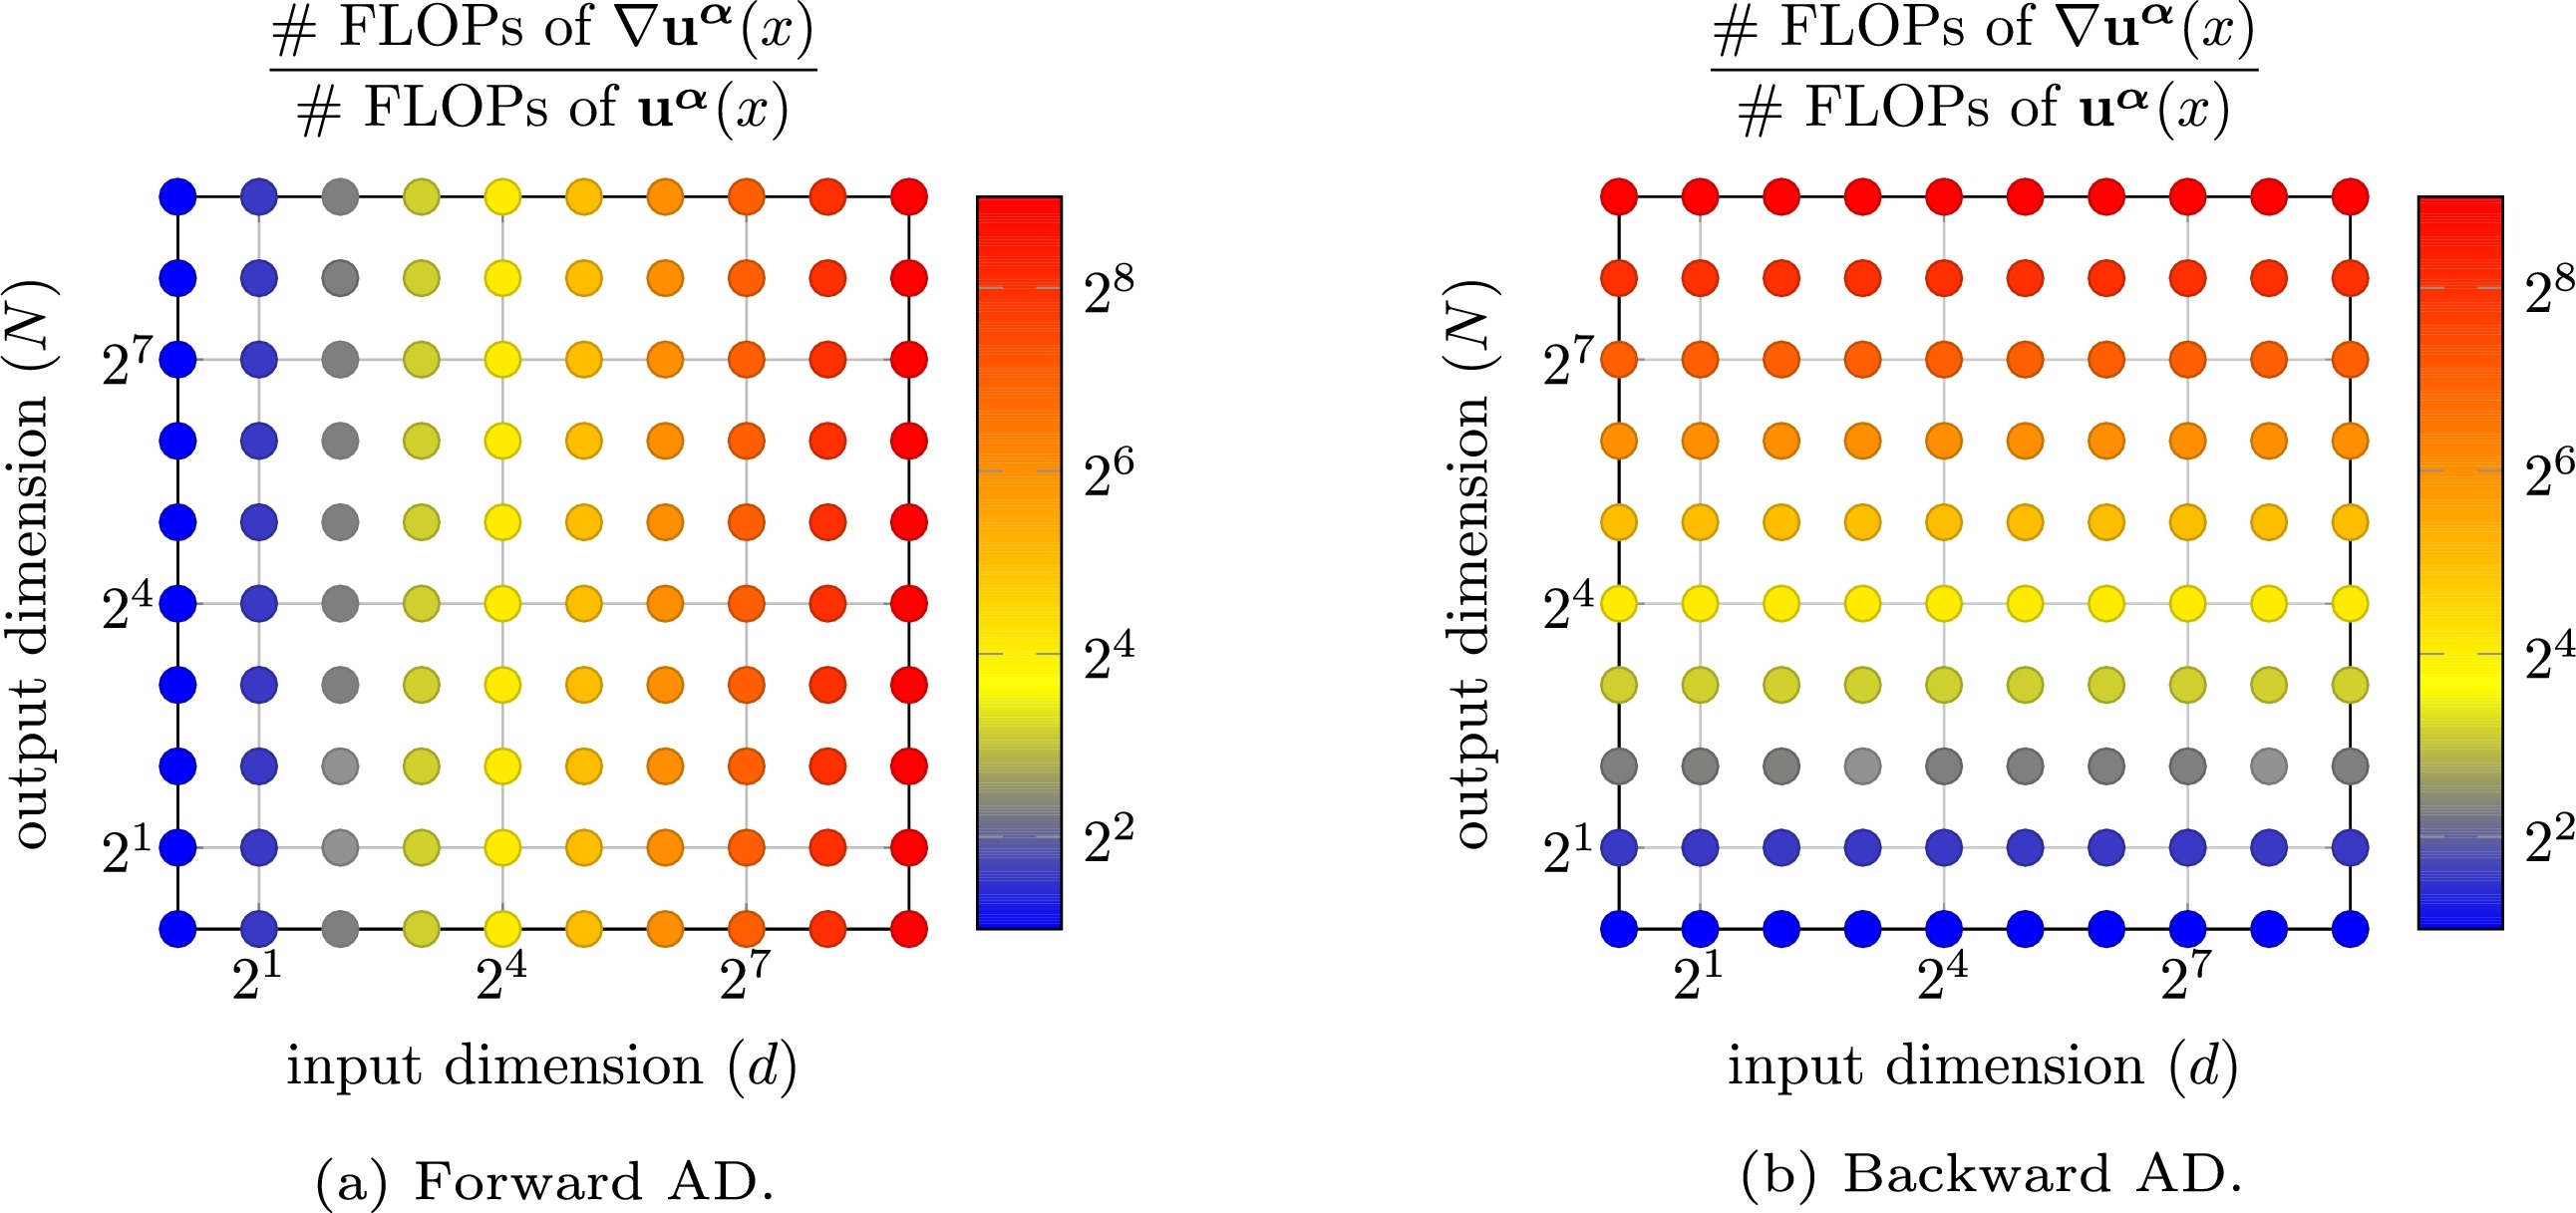

## Application: opérateurs différentiels 3D

### Des fonctions exemples

Une fonction de $\mathbb R^3\to \mathbb R$:

In [7]:
def f(xyz):

    return xyz[0]**2 + xyz[1]**3 + xyz[2]**4

jax.grad(f)(jnp.ones([3]))

Une fonction de $\mathbb R^3\to \mathbb R^3$, autrement dit, un champs de vecteurs

$$
F(x, y, z) = (x^2 y, y^2 z, z^2 x)
$$

In [8]:
def F(xyz):
    x, y, z = xyz
    return jnp.array([x**2 * y, y**2 * z, z**2 * x])

### Le gradient himself

Pour une fonction scalaire $f:\mathbb R^3\to \mathbb R$:
$$
\nabla  f
=
\begin{pmatrix}
\partial_x \\
\partial_y \\
\partial_z \\
\end{pmatrix}
f
=
\begin{pmatrix}
\partial_x f\\
\partial_y f\\
\partial_z f\\
\end{pmatrix}
$$

### Le rotationnel

On ne note souvent:
$$
\nabla \times F
$$
En effent, on peut le voir comme un produit vectoriel (noté $\times$) formel:
$$
\begin{pmatrix}
\partial_x \\
\partial_y \\
\partial_z \\
\end{pmatrix}
\times
\begin{pmatrix}
F_x \\
F_y \\
F_z \\
\end{pmatrix}
$$

In [9]:
def curl(F):
    """
    Calcule le rotationnel (curl) dune fonction F de R^3 dans R^3
    Le résultat est aussi une fonction de R^3 dans R^
    """


    @jax.jit
    def res_fn(xyz):
        # Calculate partial derivatives of each component of F
        Fx, Fy, Fz = lambda p: F(p)[0], lambda p: F(p)[1], lambda p: F(p)[2]

        δyFz = jax.grad(Fz)(xyz)[1]
        δzFy = jax.grad(Fy)(xyz)[2]

        δzFx = jax.grad(Fx)(xyz)[2]
        δxFz = jax.grad(Fz)(xyz)[0]

        δxFy = jax.grad(Fy)(xyz)[0]
        δyFx = jax.grad(Fx)(xyz)[1]

        # Compute the components of the curl
        curl_x = δyFz - δzFy
        curl_y = δzFx - δxFz
        curl_z = δxFy - δyFx

        return jnp.stack([curl_x, curl_y, curl_z])

    return res_fn

In [10]:
def curl_jacfwd(F):
    """
    Même chose, mais en utilisant la matrice jacobienne.
    """
    jax.jit
    def curl_F(x):
        jacobian = jax.jacfwd(F)(x)

        # Extract partial derivatives from the Jacobian
        dFx_dy = jacobian[0, 1]
        dFx_dz = jacobian[0, 2]
        dFy_dx = jacobian[1, 0]
        dFy_dz = jacobian[1, 2]
        dFz_dx = jacobian[2, 0]
        dFz_dy = jacobian[2, 1]

        # Compute the components of the curl
        curl_x = dFz_dy - dFy_dz
        curl_y = dFx_dz - dFz_dx
        curl_z = dFy_dx - dFx_dy

        return jnp.stack([curl_x, curl_y, curl_z])

    return curl_F

In [11]:
curl_F = curl(F)
curl_F_fwd=curl_jacfwd(F)
xyz = jnp.array([1.0, 2.0, 3.0])

curl_F(xyz)

In [12]:
curl_F_fwd(xyz)

In [13]:
%timeit curl_F(xyz).block_until_ready()
%timeit curl_F_fwd(xyz).block_until_ready()

### La divergence

On ne note souvent:
$$
\nabla \cdot F
$$
En effet, on peut le voir comme un produit scalaire formel:
$$
\begin{pmatrix}
\partial_x \\
\partial_y \\
\partial_z \\
\end{pmatrix}
\cdot
\begin{pmatrix}
F_x \\
F_y \\
F_z \\
\end{pmatrix}
$$

In [14]:
def divergence_v1(F):
    """
    Calcul la divergence d'une fonction de R^3 dans R^3
    Le résultat est une fonction de R^3 dans R
    """
    Fx=lambda x,y,z:F(jnp.stack([x,y,z]))[0]
    Fy=lambda x,y,z:F(jnp.stack([x,y,z]))[1]
    Fz=lambda x,y,z:F(jnp.stack([x,y,z]))[2]


    δxFx=jax.grad(Fx,0)
    δyFy=jax.grad(Fy,1)
    δzFz=jax.grad(Fz,2)


    @jax.jit
    def divergence_F(xyz):
        x,y,z=xyz[0],xyz[1],xyz[2]

        return δxFx(x,y,z)+δyFy(x,y,z)+δzFz(x,y,z)

    return divergence_F

In [15]:
def divergence_v2(F):
    """
    Calcul la divergence d'une fonction de R^3 dans R^3
    Le résultat est une fonction de R^3 dans R
    """
    Fx=lambda xyz:F(xyz)[0]
    Fy=lambda xyz:F(xyz)[1]
    Fz=lambda xyz:F(xyz)[2]


    @jax.jit
    def divergence_F(xyz):
        return jax.grad(Fx)(xyz)[0]+jax.grad(Fy)(xyz)[1]+jax.grad(Fz)(xyz)[2]

    return divergence_F

In [16]:
xyz = jnp.array([1.0, 2.0, 3.0])


div_F_v1=divergence_v1(F)
div_F_v2=divergence_v2(F)


print(f"Divergence_v1 at the point:{div_F_v1(xyz)}")
print(f"Divergence_v2 at the point:{div_F_v2(xyz)}")

In [17]:
%timeit div_F_v1(xyz).block_until_ready()

In [18]:
%timeit div_F_v2(xyz).block_until_ready()

***A vous:*** Pourquoi est-ce que la ligne du dessous est moins performante:

In [19]:
%timeit divergence_v1(F)(xyz).block_until_ready()

### Le laplacien

$$
\nabla^2 f = \partial_{xx}f +\partial_{yy}f +\partial_{zz}f
$$
(Parfois on le note aussi $\nabla^2 f$, parfois on garde cette seconde notation pour le laplacien vectoriel, cf plus bas).



On constate que le laplacien est la divergence du gradient. On peut le coder ainsi:

In [21]:
def laplacian(f):
    @jax.jit
    def res_fn(xyz):
        grad_f = jax.grad(f)
        return divergence_v2(grad_f)(xyz)
    return res_fn

In [22]:
#On teste en créant les fonctions à l'extérieur de la fonction retournée (elles seront jité comme des constantes)
def laplacian_bis(f):
    grad_f = jax.grad(f)
    lap_f=divergence_v2(grad_f)

    @jax.jit
    def res_fn(xyz):
        return lap_f(xyz)
    return res_fn

In [23]:
lap_f = laplacian(f)
lap_f_bis = laplacian_bis(f)

xyz = jnp.array([1.0, 2.0, 3.0])
lap_f(xyz)

In [24]:
%timeit lap_f(xyz).block_until_ready()
%timeit lap_f_bis(xyz).block_until_ready()

### Vérification des relations entre opérateurs

Nous allons vérifier les identités de calcul vectoriel en utilisant les fonctions définies précédemment et un point d'évaluation.

In [25]:
# Point d'évaluation
xyz = jnp.array([1.5, 2.5, 0.5])

# Vérification de  ∇ × (∇ f) = 0
grad_f = jax.grad(f)
curl_grad_f = curl(grad_f)
curl_grad_at_xyz = curl_grad_f(xyz)

print(f"(∇ × (∇ f)): {curl_grad_at_xyz}")
# On s'attend à un vecteur proche de zéro

In [26]:
# Vérification de ∇ ⋅ (∇ × F) = 0
curl_F = curl(F)
div_curl_F = divergence_v2(curl_F)

xyz=jnp.array([1.,2,3])
print(f" (∇ ⋅ (∇ × F)): {div_curl_F(xyz)}")
# On s'attend à une valeur scalaire proche de zéro

### Laplacien vectoriel


$$
\nabla^2 F =
\begin{pmatrix}
\partial^2_x F_x \\
\partial^2_y F_y \\
\partial^2_z F_z \\
\end{pmatrix}
$$


In [27]:
# On applique le Laplacien scalaire à chaque composante de F
def laplacian_vector(F):
    @jax.jit
    def laplacian_F(xyz):
        Fx, Fy, Fz = lambda p: F(p)[0], lambda p: F(p)[1], lambda p: F(p)[2]
        laplacian_Fx = laplacian(Fx)(xyz)
        laplacian_Fy = laplacian(Fy)(xyz)
        laplacian_Fz = laplacian(Fz)(xyz)
        return jnp.array([laplacian_Fx, laplacian_Fy, laplacian_Fz])
    return laplacian_F

In [29]:
# Vérification de ∇ × (∇ × F) = ∇ (∇ ⋅ F) - ∇² F

# Côté gauche: ∇ × (∇ × F)
curl_F = curl(F)
curl_curl_F = curl(curl_F)
lhs_at_xyz = curl_curl_F(xyz)

# Côté droit: ∇ (∇ ⋅ F) - ∇² F
# Calculer ∇ (∇ ⋅ F)
div_F = divergence_v2(F)
grad_of_div_F = jax.grad(div_F)
grad_of_div_at_xyz = grad_of_div_F(xyz)


laplacian_F = laplacian_vector(F)
laplacian_F_at_point = laplacian_F(xyz)

# Calculer le côté droit complet
rhs_at_point = grad_of_div_at_xyz - laplacian_F_at_point

print(f"Vérification de (∇ × (∇ × F) vs ∇ (∇ ⋅ F) - ∇² F):")
print(f"Côté gauche (∇ × (∇ × F)):     {lhs_at_xyz}")
print(f"Côté droit (∇ (∇ ⋅ F) - ∇² F): {rhs_at_point}")

# On s'attend à ce que ces deux vecteurs soient très proches

### Laplacien via la trace de la Hessienne

Le Laplacien d'une fonction scalaire $f$ peut également être calculé comme la trace de sa matrice Hessienne.
$$
\Delta f = \text{Tr}(H f)
$$
où
$$
Hf=
\begin{pmatrix}
\partial_{xx}f & \partial_{xy}f & \partial_{xz}f\\
\partial_{yx}f & \partial_{yy}f & \partial_{yz}f\\
\partial_{zx}f & \partial_{zy}f & \partial_{zz}f
\end{pmatrix}
$$

In [30]:
def laplacian_via_hessian(f):
    @jax.jit
    def laplacian_f(x):
        hessian_f = jax.hessian(f)(x)
        return jnp.trace(hessian_f)

    return laplacian_f

**Exemple d'utilisation avec la même fonction scalaire :**

Considérons toujours la fonction scalaire $f(x, y, z) = x^2 + y^3 + z^4$.

In [31]:
xyz = jnp.array([1.0, 2.0, 3.0])

Δf_at_xyz = laplacian_via_hessian(f)(xyz)
Δf_at_xyz

In [34]:
Δf=laplacian(f)
Δf(xyz)

In [35]:
Δf_=laplacian_via_hessian(f)
Δf_(xyz)

In [36]:
%timeit Δf(xyz).block_until_ready()

In [37]:
%timeit Δf_(xyz).block_until_ready()

## Défi prog: les opérateurs en 2d


Complétez les programmes


Attention: Le rotationnel 2d est une fonction scalaire:
$$
\partial_x F_y - \partial_y F_x
$$

On peut le voir comme la composante en $z$ du rotationnel d'un  champs d'un champs de vecteur sur $R^3$  qui est confiné dans $\mathbb R^2$:
$$
(x,y,z) \to
\begin{pmatrix}
F_x(x,y,0)\\
F_y(x,y,0)\\
0\\
\end{pmatrix}
$$






In [38]:
def f_of_xy(xy):
    return jnp.sin(xy[0]) * jnp.cos(xy[1])

#fonctions
f_of_xyV = ...
δf_of_xy = ...
δf_of_xyV  =...


#grille
x = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 100)
y = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 100)
X_mat, Y_mat = jnp.meshgrid(x, y)
shape=X_mat.shape
xyV=jnp.stack([X_mat.flatten(),Y_mat.flatten()],axis=1)


#évaluation des fonctions
f_at_xyV = ...
δf_at_xyV = ...
δfx_at_xyV_mat=(δf_at_xyV[:,0]).reshape(shape)
δfy_at_xyV_mat=(δf_at_xyV[:,1]).reshape(shape)


#graphique
fig, ax = plt.subplots(figsize=(8, 6))
f_at_xyV_mat=f_at_xyV.reshape(shape)
aaa = ax.pcolormesh(X_mat, Y_mat, f_at_xyV_mat,shading="gouraud")
fig.colorbar(aaa, ax=ax, label='Valeurs de f(x, y)')
step = 5
ax.quiver(X_mat[::step, ::step],Y_mat[::step, ::step],
           δfx_at_xyV_mat[::step, ::step], δfy_at_xyV_mat[::step, ::step],
           scale=20, color='white', width=0.003, alpha=0.9)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('f(x,y) = sin(x) cos(y) avec gradient en flèches')
plt.show()

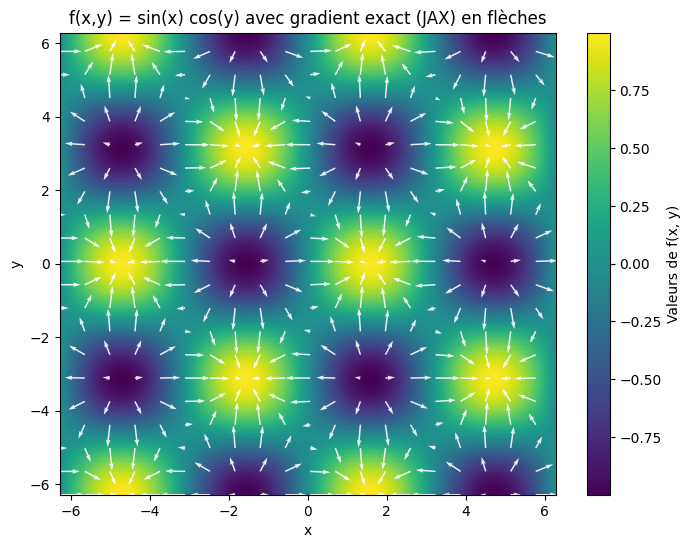

In [38]:
#--- To keep following outputs, do not run this cell! ---

In [40]:
def F_of_xy(xy):
    """
    Fonction de R^2 dans R^2 (= un champ de vecteur).
    :param xy: f[2]
    :return:   f[2]
    """
    x=xy[0]
    y=xy[1]
    n=jnp.linalg.norm(xy)+5
    return jnp.stack([y/n,-x/n])

In [41]:
def curl_fnm(F_of_xy):
    """
    Calcule le rotationnel d'un champ de vecteur sur R^2.
    :param F_of_xy: Fonction R^2 → R^2
    :return: Fonction R^2 → R
    """
    ...


In [42]:

#fonctions
curl_F_of_xyV=jax.vmap(curl_fnm(F_of_xy))
F_of_xyV=jax.vmap(F_of_xy)


# Grille sur R^2
x = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 100)
y = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 100)
X_mat, Y_mat = ...
shape=X_mat.shape
xyV=jnp.stack([...

# evaluation des fonctions
F_at_xyV=...
Fx_at_xyV_mat=...
Fy_at_xyV_mat=...
curl_F_at_xyV_mat=curl_F_of_xyV(xyV).reshape(shape)


#graphique
fig, ax = plt.subplots(figsize=(8, 6))
aaa = ax.pcolormesh(X_mat, Y_mat, curl_F_at_xyV_mat,shading="gouraud")
fig.colorbar(aaa, ax=ax, label='rot F')

step = 5
ax.quiver(X_mat[::step, ::step],...
            Fx_at_xyV_mat[::step, ::step], Fy_at_xyV_mat[::step, ::step],
            scale=10, color='red', width=0.003, alpha=0.9)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('champs de vecteur (flèches) et son rotationnel (couleur)')
plt.show()

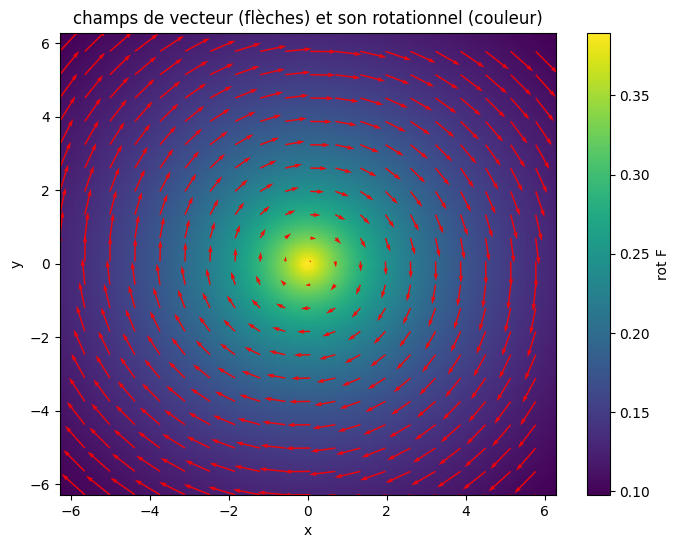

In [42]:
#--- To keep following outputs, do not run this cell! ---

En observant ces deux graphiques, expliquez intuitivement pourquoi le rotationnel d'un champs construit à partir d'un gradient est nul.